In [1]:
from torch import empty
import math

In [43]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

[Go to Benchamrking](#Benchmarking) with Pytorch

In [44]:
#I dont know why we need this?
class Module ( object ):
    
    def forward (self , input_ ):
        return input_
    def backward (self, grad):
        
        #Call backward() for previous module
        if self.prev_module is not None:
            prev_grads = self.prev_module.backward(grad)
            
    def param ( self ):
        return []

In [45]:
class LossMSE(Module):
    
    def __init__(self, prev_module = None):
        self.prev_module =  prev_module
    
    def set_truth(self,y_true):
        self.y_true = y_true
    
    def forward (self , input_ ):
        assert input_.shape[0] == self.y_true.shape[0], "Batch size must match!"
        assert input_.shape[1] == self.y_true.shape[1], "Input and output size must match!"
        self.curr_input = input_
        return (self.y_true-input_).square().mean(1,True)  #Average per input not accross batches!
    
    def backward (self):
        #Calculate gradient

        grad = -2 *(self.y_true-self.curr_input) / (self.curr_input.shape[1])   #Divide by number of output samples not batch size     

        #Call backward() for previous module
        if self.prev_module is not None:
            prev_grads = self.prev_module.backward(grad)
    
    def param ( self ):
        return []
    

In [46]:
class ReLU(Module):
    
    def __init__(self, prev_module = None):
        self.prev_module =  prev_module
        self.curr_grad = 0 #Temporary

    def forward (self , input_ ):
        self.curr_grad = (input_ > 0)
        return input_ * self.curr_grad
        
    def backward (self , gradwrtoutput):
        #Calculate gradient
        grad = self.curr_grad * gradwrtoutput
        
        #Call backward() for previous module
        if self.prev_module is not None:
            prev_grads = self.prev_module.backward(grad)
    
    def param ( self ):
        return []
    
class Tanh(Module):
    
    def __init__(self, prev_module = None):
        self.prev_module =  prev_module
        self.curr_grad = 0 #Temporary

    def forward (self , input_ ):
        self.curr_grad = input_.tanh()
        return self.curr_grad
        
    def backward (self , gradwrtoutput):
        #Calculate gradient        
        grad = self.curr_grad.tanh().pow(2).multiply(-1).add(1) * gradwrtoutput
        
        #Call backward() for previous module
        if self.prev_module is not None:
            prev_grads = self.prev_module.backward(grad)
    
    def param ( self ):
        return []

In [50]:
#TODO there is a bug in here somewhere
class FCC(Module):
    
    def __init__(self, input_size, output_size, prev_module = None, lr=1e-1, N = None,init_weights = None):
        self.input_size = input_size
        self.output_size = output_size
        self.prev_module =  prev_module

        # Uniform initialization
#         self.weights = empty(input_size, output_size).normal_(0, math.sqrt(2/(input_size + output_size)))
        self.weights = empty(input_size, output_size).uniform_(-1* math.sqrt(1/input_size),math.sqrt(1/input_size) )
        self.bias = empty(1,output_size).uniform_(-1* math.sqrt(1/input_size),math.sqrt(1/input_size) )
        self.initial_weights = self.weights
        self.curr_input = 0
        self.lr = lr
        self.batch_size = 1

    def forward (self , input_ ):
        assert input_.shape[1] == self.input_size, "Input size must match!" 
        out = input_ @ (self.weights) 
        out += self.bias
        assert out.shape[1] == self.output_size, "Output size must match!" 
        assert out.shape[0] == input_.shape[0], "Batch size is not consistent!"
        self.curr_input = input_
        self.batch_size = input_.shape[0]
        return out
        
    def backward (self , gradwrtoutput):
        #Calculate gradient
        grad = gradwrtoutput @ (self.weights.T)
        
        #update weights
        self.update(gradwrtoutput, self.lr)  #This is the correct version
        #self.update(grad, self.lr)
        
        #Call backward() for previous module
        if self.prev_module is not None:
            prev_grads = self.prev_module.backward(grad)
    
    def update(self, gradwrtoutput, learning_rate):
        self.weights -= learning_rate * ( self.curr_input.T @ gradwrtoutput ) / self.batch_size
        self.bias -= learning_rate * gradwrtoutput.mean(0,True)
        
    def param ( self ):
        return [self.weights, self.bias]
    
    def initials(self):
        return self.initial_weights
    

In [51]:
class NN_builder():
    
    def __init__(self):
        self.layers = []
        layer0 = FCC(2,10)
        self.layers.append(layer0)
        layer1 = ReLU(layer0)
        self.layers.append(layer1)
        layer2 = FCC(10,1, prev_module = layer1)
        self.layers.append(layer2)
        layer3 = ReLU(layer2)
        self.layers.append(layer3)
        layer4 = LossMSE(layer3)
        self.layers.append(layer4)
    
    def model_train(self,input_, g_truth):
        curr = input_
        self.layers[-1].set_truth(g_truth)
        for layer in self.layers:
            curr = layer.forward(curr)
        self.layers[-1].backward()        
        
    def model_eval(self,input_):
        curr = input_
        for layer in self.layers[:-1]:
            curr = layer.forward(curr)
            #print(curr)
        return curr
    

In [52]:
class Sequential(object):
    def __init__(self, layer_list, arguments, loss='MSE', lr = 2 * 1e-2):
        self.layers = []
        last_layer = None        
        for idx ,layer_name in enumerate(layer_list):
            if(layer_name == 'FCC'):
                assert arguments[idx] != [], "FCC requires a tuple as input!"
                curr_layer =FCC(arguments[idx][0], arguments[idx][1], last_layer, lr=lr)
                self.inits = curr_layer.initials()
                self.layers.append(curr_layer)
                last_layer = curr_layer
            elif(layer_name == 'ReLU'):
                assert arguments[idx] == [], "Relu requires no input!"
                curr_layer = ReLU(last_layer)
                self.layers.append(curr_layer)
                last_layer = curr_layer
            elif(layer_name == 'Tanh'):
                assert arguments[idx] == [], "Tanh requires no input!"
                
                curr_layer = Tanh(last_layer)
                self.layers.append(curr_layer)
                last_layer = curr_layer
            else:
                raise Exception("No Module matches the input")

        if loss == 'MSE':
            curr_layer = LossMSE(last_layer)
            self.layers.append(curr_layer)
        else:
            raise Exception("No Loss matches the input")
                
    def train(self,input_, g_truth):
        out = input_
        self.layers[-1].set_truth(g_truth)
        for layer in self.layers[:-1]:
            out = layer.forward(out)
        loss = self.layers[-1].forward(out)
        self.layers[-1].backward()  
        return out,loss.mean()
        
    def eval(self,input_):
        out = input_
        for layer in self.layers[:-1]:
            out = layer.forward(out)
        return out
    
    def get_inits(self):
        return self.inits

### These two are just for a quick check I know they are terrible :D

In [53]:
def stupid_test_function(a,b):
    if a == 0 or b == 0:
        return 0
    else:
        return 1

In [54]:
def stupid_acc_func(pred,true):
    pred = pred.item() > 0.5
    return (pred == true.item())
    

In [55]:
import torch

In [64]:
def modelTrainer(train_input,train_target,test_input,test_target,test_size):
    seq = Sequential(["FCC","ReLU","FCC"],[[2,8],[], [8,1]],"MSE")
    loss_track = []
    for epoch in range(1000):
        minibatch = 200
        for i in range(0, train_input.size(0), minibatch):
            out,loss = seq.train(train_input.narrow(0, i, minibatch), train_target.narrow(0, i, minibatch).unsqueeze(1))
        if epoch %200 == 0:
            print("Loss:", loss.item())
        loss_track.append(loss)
    plt.figure()
    plt.plot(loss_track)
    print("---------------------------------")
    acc = 0
    count = 0
    for i in range(test_size):
        truth = test_target[i].unsqueeze(0).unsqueeze(1)
        inp = test_input[i,:].unsqueeze(0)
        out = seq.eval(inp)
        #print(out)
        if stupid_acc_func(out,truth):
            acc = acc + 1
    return seq, acc /test_size

Loss: 0.7210690379142761
Loss: 0.23924045264720917
Loss: 0.21720457077026367
Loss: 0.20015232264995575
Loss: 0.17859716713428497
---------------------------------
Loss: 0.27773746848106384
Loss: 0.23824766278266907
Loss: 0.21514342725276947
Loss: 0.18695978820323944
Loss: 0.16098681092262268
---------------------------------
Loss: 0.3982160985469818
Loss: 0.20538273453712463
Loss: 0.153428852558136
Loss: 0.11183231323957443
Loss: 0.09283115714788437
---------------------------------
Loss: 0.6623542904853821
Loss: 0.20270128548145294
Loss: 0.1343614161014557
Loss: 0.09391167759895325
Loss: 0.0839838758111
---------------------------------
Loss: 0.29579591751098633
Loss: 0.24217037856578827
Loss: 0.23200301826000214
Loss: 0.20502226054668427
Loss: 0.18697276711463928
---------------------------------
Loss: 0.33906441926956177
Loss: 0.23753249645233154
Loss: 0.22809499502182007
Loss: 0.22375813126564026
Loss: 0.2139124870300293
---------------------------------
Loss: 0.8919556140899658
Lo

0.945

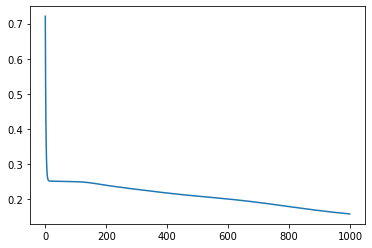

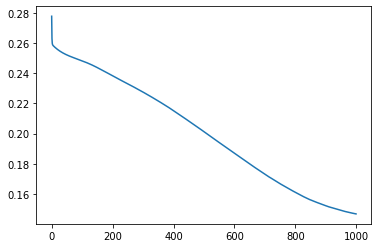

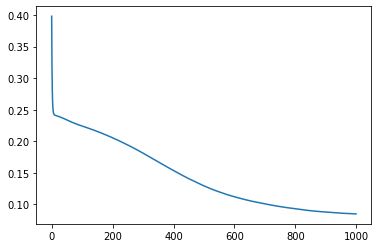

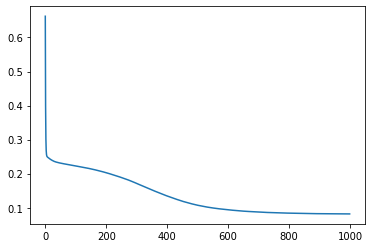

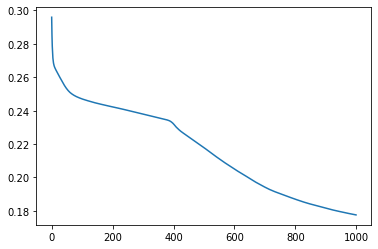

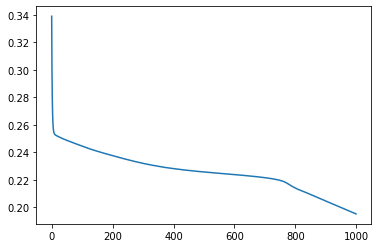

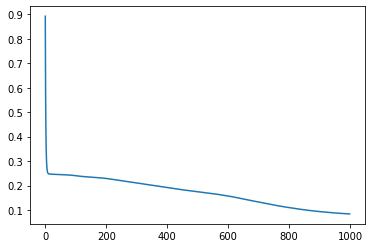

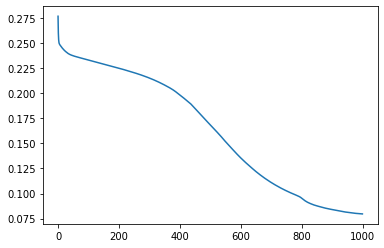

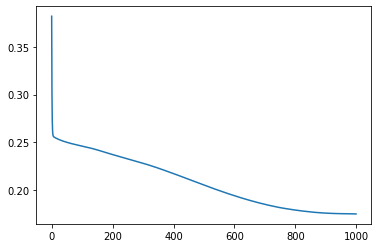

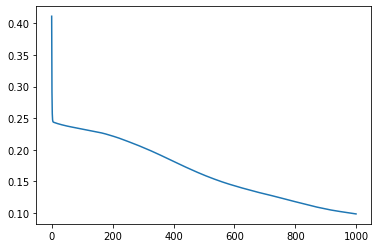

In [65]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)



models = []
best_acc = 0
curr_acc = 0
best_idx = -1
for idx in range(10):    
    model,curr_acc = modelTrainer(train_input,train_target,valid_input,valid_target,valid_size) 
    models.append(model)
    if (curr_acc > best_acc):
        best_acc = curr_acc
        best_idx = idx

acc = 0
count = 0
for i in range(test_size):
    truth = test_target[i].unsqueeze(0).unsqueeze(1)
    inp = test_input[i,:].unsqueeze(0)
    out = models[best_idx].eval(inp)
    #print(out)
    if stupid_acc_func(out,truth):
        acc = acc + 1
acc /test_size

In [62]:
best_idx

5

In [63]:
test_target

tensor([0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        1., 1.])

In [207]:
builder = NN_builder()
test = empty(1000,2).random_(0,2)
for i in range(1000):
    truth = empty(1,1).fill_(stupid_test_function(test[i,0],test[i,1]))
    inp = test[i,:].unsqueeze(0)
    out = builder.model_train(inp,truth)
    
test2 = empty(100,2).random_(0,2)
acc = 0
count = 0
for i in range(100):
    truth = empty(1,1).fill_(stupid_test_function(test2[i,0],test2[i,1]))
    inp = test2[i,:].unsqueeze(0)
    out = builder.model_eval(inp)
    #print(out)
    if out.item() > 0.5:
        count = count + 1
    if stupid_acc_func(out,truth):
        acc = acc + 1
acc /100

0.7

### Benchmarking

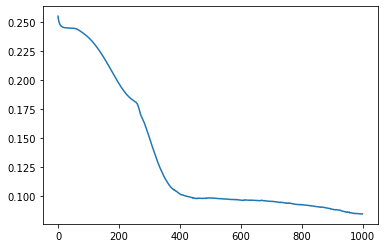

In [59]:
from torch import optim, Tensor, nn
from torch import Tensor
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)

def create_model():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
#         nn.ReLU(),
    )

def train_model(model, train_input, train_target):
    loss_track = []
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.1)
    mini_batch = 200
    # Iterate through epochs
    for i in range(1000):
        #Iterate t hrough mini batches
        for b in range(0, train_input.size(0), mini_batch):
            # Forward pass selecting the corresponding minibacth
            output = model(train_input.narrow(0, b, mini_batch))
            # Calculate loss
            loss = loss_func(output.squeeze(), train_target.narrow(0, b, mini_batch))
#             print("Loss:", loss.item())
            # Reset zero grad
            model.zero_grad()
            # Backward pass
            loss.backward()
            #Update step
            optimizer.step()
        loss_track.append(loss)
    plt.plot(loss_track)
    
def compute_nb_errors(model, data_input, data_target):
        output = model(data_input)
        comp = output.argmax(dim = 1) != data_target.argmax(dim = 1)
        nb_errors = torch.where(comp)[0].size()[0]
        error_rate = nb_errors/data_input.size(0)
        print(f'There were a total of {nb_errors} errors, or {error_rate} of the testing set.')
        
        
model = create_model()
train_model(model, train_input, train_target)
# compute_nb_errors(model, test_input, test_target)